# Section 0 - Requirements, Const variables and helper functions

In [24]:
#please change the value to True to run the reasoner
RUN_REASONER = False 

In [25]:
from csv import DictReader
from datetime import datetime
from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import Graph, URIRef, Literal, Namespace, RDF, RDFS, OWL, DC, DCTERMS
from owlready2 import get_ontology, sync_reasoner_pellet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
import plotly.graph_objects as go

In [26]:
def camelCase(text: str):
    return "".join([letter for letter in text if letter.isalpha() or letter == " "]).title().replace(" ", "")

# Section 1 - Ontology population

In this section the knowledge graph is created by populating the empty ontology with instances and creating their relationships.

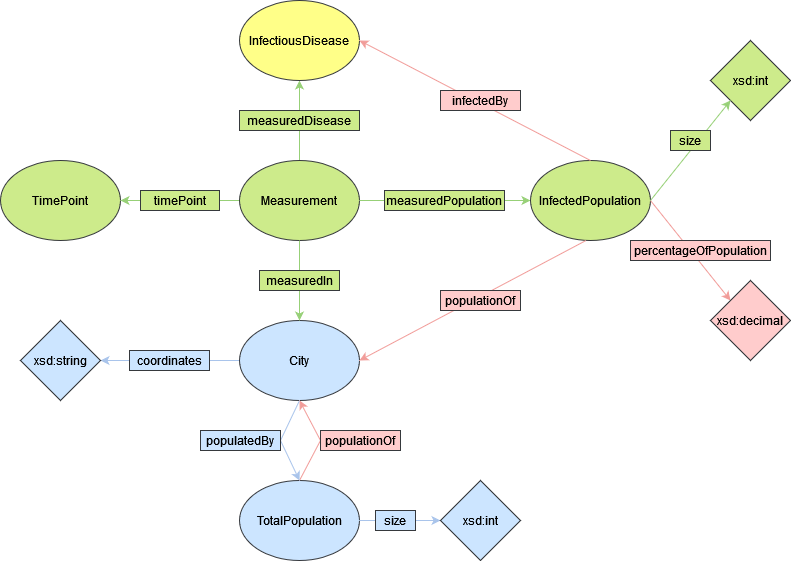
  
The yellow part of this graph is created in Subsection 1.2 - Infectious Diseases 
The blue parts of this graph are created in Subsection 1.3 - Cities and Population  
The green parts of this graph are created in Subsection 1.4 - Measurements  
The red parts of this graph are created in Subsection 1.6 - Pellet Reasoner 

## Subsection 1.1 - Ontology extension

In this subsection the epi ontology is extended and linked to the human disease ontogy.

In [27]:
EPI = Namespace("http://github.com/jkuwalek/vrije-KnD-final-project/ontology/")
XSD = Namespace("http://www.w3.org/2001/XMLSchema#")
HDO = Namespace("http://purl.obolibrary.org/obo/")
GEN = Namespace("http://www.geneontology.org/formats/oboInOwl#")

graph = Graph()
with open("./data/epi-blank.ttl", "r") as f:
    graph.parse(f, format="turtle")

human_disease_ontology = Graph()
human_disease_ontology.parse(
    "https://raw.githubusercontent.com/DiseaseOntology/HumanDiseaseOntology/v2024-09-27/src/ontology/doid.owl",
    format="xml",
)

# Remove annotation properties that do not describe the joint ontology
human_disease_ontology.remove((HDO["doid.owl"], DC.title, Literal("Human Disease Ontology")))
human_disease_ontology.remove((HDO["doid.owl"], HDO["DOID_4"], None))
human_disease_ontology.remove((HDO["doid.owl"], DC.description, Literal(
    "The Disease Ontology has been developed as a standardized ontology for human disease with the purpose of providing the biomedical community with consistent, reusable and sustainable descriptions of human disease terms, phenotype characteristics and related medical vocabulary disease concepts."
)))
human_disease_ontology.remove((HDO["doid.owl"], DCTERMS.license, URIRef("https://creativecommons.org/publicdomain/zero/1.0/")))
human_disease_ontology.remove((HDO["doid.owl"], GEN.date, Literal("27:09:2024 15:14")))
human_disease_ontology.remove((HDO["doid.owl"], GEN["default-namespace"], Literal("disease_ontology")))
human_disease_ontology.remove((HDO["doid.owl"], GEN["saved-by"], Literal("lschriml")))
human_disease_ontology.remove((HDO["doid.owl"], RDFS.comment, Literal(
    "The Disease Ontology content is available via the Creative Commons Public Domain Dedication CC0 1.0 Universal license (https://creativecommons.org/publicdomain/zero/1.0/)."
)))
human_disease_ontology.remove((HDO["doid.owl"], OWL.versionIRI, URIRef("http://purl.obolibrary.org/obo/doid/releases/2024-09-27/doid.owl")))
human_disease_ontology.remove((HDO["doid.owl"], OWL.versionInfo, Literal("2024-09-27")))
graph += human_disease_ontology

graph.bind("epi", EPI)
graph.bind("xsd", XSD)
graph.bind("hdo", HDO)
graph.bind("gen", GEN)

graph.add((EPI.Disease, OWL.equivalentClass, HDO.DOID_4)) # sameAs disease
graph.add((EPI.InfectiousDisease, OWL.equivalentClass, HDO.DOID_0050117)) # equivalentClass diseases by infectious agent

graph.serialize("generated_files/epi-extended.ttl", format="ttl")

<Graph identifier=N19b0739459074464a5b5d1eabcb3b574 (<class 'rdflib.graph.Graph'>)>

## Subsection 1.2 - Infectious Diseases (Yellow)

In this section the disease is specified, and is classified in the context of the human disease ontology. This classification is a manual process and has to be specified for every disease added. 

In [28]:
DISEASE_NAME = "Covid-19"
DISEASE_TAG = "C19"

graph.add((EPI[DISEASE_TAG], RDF.type, HDO.DOID_10533)) # type Viral pneumonia
graph.add((EPI[DISEASE_TAG], RDFS.label, Literal(DISEASE_NAME, lang="nl")))
graph.add((EPI[DISEASE_TAG], RDFS.label, Literal(DISEASE_NAME, lang="en")))

<Graph identifier=N19b0739459074464a5b5d1eabcb3b574 (<class 'rdflib.graph.Graph'>)>

## Subsection 1.3 - Cities and Population (Blue)

In this section the ontology is populated with dutch cities and their respective populations.

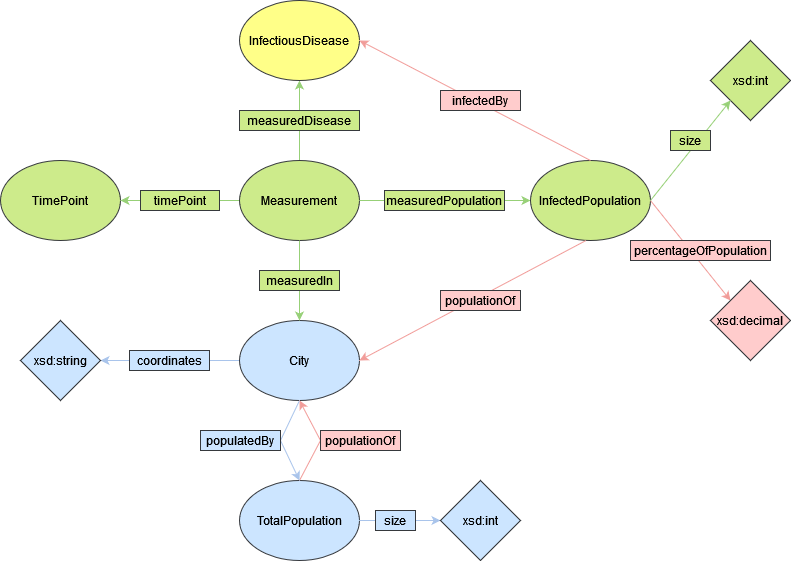

In [29]:
CITIES = {}
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
sparql.setReturnFormat(JSON)

sparql.setQuery(
    """
    SELECT DISTINCT ?city ?cityLabel_nl ?cityLabel_en ?population ?coordinates WHERE {
        ?city wdt:P31 wd:Q515 . # instance of city
        ?city wdt:P17 wd:Q55 . # country Netherlands
        ?city wdt:P1082 ?population .
        ?city rdfs:label ?cityLabel_en.
        ?city rdfs:label ?cityLabel_nl.
        ?city wdt:P625 ?coordinates.

        FILTER(LANG(?cityLabel_en) = "en")
        FILTER(LANG(?cityLabel_nl) = "nl")
    }
    """
)

try:
    ret = sparql.queryAndConvert()
    if not isinstance(ret, dict):
        raise Exception("not isinstance(ret, dict)")

    for city in ret["results"]["bindings"]:
        CITIES[camelCase(city["cityLabel_nl"]["value"])] = [city["population"]["value"], city["cityLabel_nl"]["value"], city["cityLabel_en"]["value"], city["coordinates"]["value"]]

    for city_name, (population, label_nl, label_en, coordinates) in CITIES.items():
        city_uri = EPI[city_name]
        population_uri = EPI[f"PopulationOf{ city_name }"]
        
        # Data Properties
        graph.add((city_uri, EPI.populatedBy, population_uri))
        graph.add((city_uri, EPI.coordinates, Literal(coordinates)))
        graph.add((city_uri, RDF.type, EPI.City))
        graph.add((population_uri, EPI.size, Literal(population, datatype=XSD["int"])))

        # Labels
        graph.add((city_uri, RDFS.label, Literal(label_nl, lang="nl")))
        graph.add((city_uri, RDFS.label, Literal(label_en, lang="en")))
        graph.add((population_uri, RDFS.label, Literal(f"Population of {label_nl}", lang="nl")))
        graph.add((population_uri, RDFS.label, Literal(f"Population of {label_en}", lang="en")))
        
except Exception as e:
    print(e)
else:
    print("Success!")

Success!


## Subsection 1.4 - Measurements (Green)

In this subsection the measurements are extracted from a csv file and inserted into the ontology.

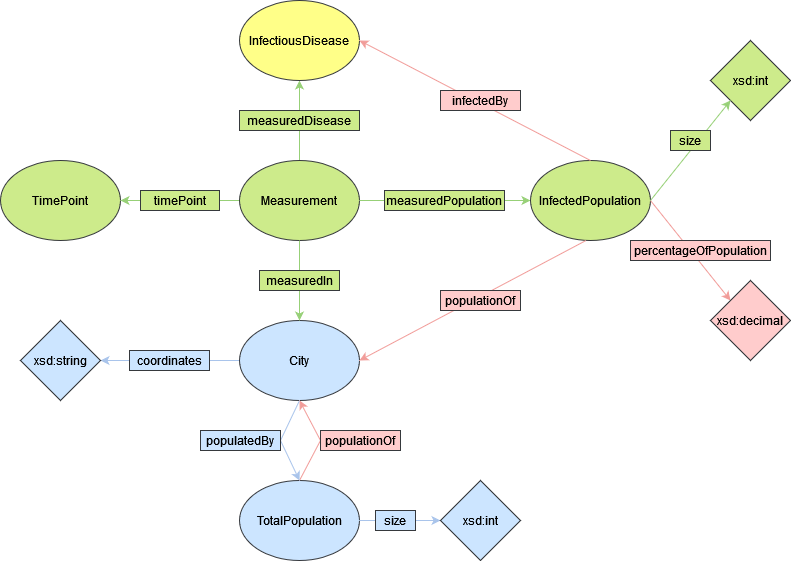

In [30]:
measurements = {}
cumulative_time_interval_data = {}
counter = 0
ommited_cities = set()
current_date = None

with open("./data/COVID-19_aantallen_gemeente_per_dag.csv") as f:
    data = DictReader(f, delimiter=";")

    for dataPoint in data:
        city_name = camelCase(dataPoint["Municipality_name"])

        if city_name not in CITIES:
            ommited_cities.add(city_name)
            continue
        
        time_point = dataPoint["Date_of_publication"]
        
        if time_point != current_date:
            if counter % 14 == 0:
                # At the start of every 14 day period log the current data
                for city in cumulative_time_interval_data:
                    measurements[city] = measurements.get(city, {})
                    measurements[city][current_date] = cumulative_time_interval_data[city]

            counter += 1
            current_date = time_point

        cumulative_time_interval_data[city_name] = cumulative_time_interval_data.get(city_name, 0) + int(dataPoint["Total_reported"])

encountered_time_points = []
for city_name, data in measurements.items():
    for time_point, total_infected in data.items():
        city_uri = EPI[city_name]
        measurement_uri = EPI["M" + DISEASE_TAG + city_name + time_point]
        infected_population_uri = EPI["IP" + DISEASE_TAG + city_name + time_point]
        time_point_uri = EPI[time_point]

        time_point_label = datetime.strptime(time_point, "%Y-%m-%d").strftime("%B %d, %Y")
        measurement_label = f"Measurement of {DISEASE_NAME} in {CITIES[city_name][2]} on {time_point_label}"
        infected_population_label = f"Infected population of {CITIES[city_name][2]} by {DISEASE_NAME} on {time_point_label}"

        graph.add((measurement_uri, EPI.measuredIn, city_uri))
        graph.add((measurement_uri, EPI.measuredPopulation, infected_population_uri))
        graph.add(
            (infected_population_uri, EPI.size, Literal(total_infected, datatype=XSD["int"]))
        )
        graph.add((measurement_uri, EPI.measuredAt, time_point_uri))
        graph.add((measurement_uri, EPI.measuredDisease, EPI[DISEASE_TAG]))

        graph.add((measurement_uri, RDFS.label, Literal(measurement_label, lang="en")))
        graph.add((infected_population_uri, RDFS.label, Literal(infected_population_label, lang="en")))        
        if time_point not in encountered_time_points:
            encountered_time_points.append(time_point)
            graph.add((time_point_uri, RDFS.label, Literal(time_point_label, lang="en")))


print("Success!")
# print("The following cities have not been included in the knowledge graph:", "\n".join(ommited_cities))

Success!


## Subsection 1.5 - Exporting explicit triples

In this section the explicit triples created in the previous steps are exported in xml format.

In [31]:
try:
    graph.serialize(destination="generated_files/epi-explicit.owl", format="xml")
except Exception as e:
    print(e)
else:
    print("Success!")

Success!


## Subsection 1.6 - Pellet Reasoner (Red)

In this subsection new triples are inferred based on the explicit triples and rules generated in the previous steps.

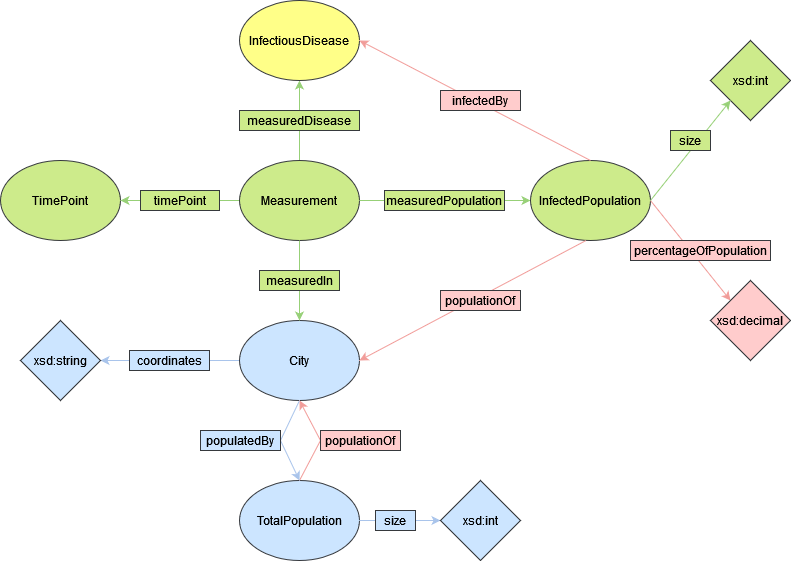

In [32]:
if RUN_REASONER:
    epi = get_ontology("generated_files/epi-explicit.owl").load()

    with epi:
        sync_reasoner_pellet(infer_property_values=True, infer_data_property_values=True)

        # owlready2 is only capable of storing the data in xml format,
        # therefore we store it as xml and then convert to ttl too
        epi.save(file="generated_files/epi_with_inferrences.owl", format="rdfxml")

    print("Success!")


# Section 2 - Data extraction

In [33]:

full_knowledge_graph = Graph()
full_knowledge_graph.parse("./generated_files/epi_with_inferrences.owl", format="xml")
full_knowledge_graph.bind("epi", EPI)
full_knowledge_graph.bind("xsd", XSD)
full_knowledge_graph.bind("hdo", HDO)
full_knowledge_graph.bind("gen", GEN)

## Subsection 2.1 - Data extraction for map visualisation


In [34]:
visualization_data_sparql_result = full_knowledge_graph.query("""
SELECT DISTINCT ?cityName ?measuredInfectedPopulationSize ?measurementDate ?coordinates ?cityPopulationSize WHERE {
    ?city a epi:City .
    ?city rdfs:label ?cityName .
    ?city epi:coordinates ?coordinates .
    ?city epi:populatedBy ?cityPopulation .
    ?cityPopulation epi:size ?cityPopulationSize .
                                                              
    ?measurement epi:measuredIn ?city .
    ?measurement epi:measuredAt ?measurementDate .
    ?measurement epi:measuredDisease epi:C19 .
    ?measurement epi:measuredPopulation ?measurementPopulation .
    ?measurementPopulation epi:size ?measuredInfectedPopulationSize .

    FILTER(LANG(?cityName) = "en")
}
ORDER BY ?measurementDate
""")

visualization_infected_data = {}
visualization_coordinate_data = {}
for row in visualization_data_sparql_result:
    cityName = str(row.cityName)
    if cityName not in visualization_infected_data:
        visualization_infected_data[cityName] = {}

    if cityName not in visualization_coordinate_data:
        visualization_coordinate_data[cityName] = {}

    visualization_infected_data[cityName][str(row.measurementDate).split("/")[-1]] = (
        int(row.measuredInfectedPopulationSize)
    )

    [longitude, latitude] = row.coordinates.split(" ")
    longitude, latitude = (
        longitude.replace("Point(", "").strip(),
        latitude.replace(")", "").strip(),
    )
    visualization_coordinate_data[cityName] = {
        "size": int(row.cityPopulationSize),
        "long": float(longitude),
        "lat": float(latitude),
    }

## Subsection 2.2 - Heat Map visualisation

In [35]:
class DataManager:
    def __init__(self, infections_data, coords_size_data):
        self.infections_data: dict = infections_data
        self.coords_size_data: dict = coords_size_data

    def _get_list_of_cities(self) -> list:
        return list(self.coords_size_data.keys())

    def _get_all_dates(self) -> list:
        example_city = self._get_list_of_cities()[0]
        return list(self.infections_data[example_city].keys())

    def _get_city_coordinates(self, city: str):
        return self.coords_size_data[city]["lat"], self.coords_size_data[city]["long"]

    def _get_amount_of_infections(self, city: str, date: str) -> int:
        return self.infections_data[city][date]

    def run_graph_with_slider(self) -> None:
        dates = self._get_all_dates()
        frames = []
        initial_data = []

        for city in self._get_list_of_cities():
            lat, lon = self._get_city_coordinates(city)
            infections = self._get_amount_of_infections(city, dates[0])
            color_scale = min(infections / 1500, 1)
            initial_data.append(
                go.Scattermapbox(
                    lat=[lat],
                    lon=[lon],
                    mode="markers",
                    marker=go.scattermapbox.Marker(
                        size=10 + infections / 1000,
                        color=f"rgba(255, 0, 0, {color_scale})",
                        opacity=0.7,
                    ),
                    name=city,
                    text=[f"{city}: {infections} cases on {dates[0]}"],
                )
            )

        for date in dates:
            frame_data = []
            for city in self._get_list_of_cities():
                lat, lon = self._get_city_coordinates(city)
                infections = self._get_amount_of_infections(city, date)
                color_scale = min(infections / 1500, 1)
                frame_data.append(
                    go.Scattermapbox(
                        lat=[lat],
                        lon=[lon],
                        mode="markers",
                        marker=go.scattermapbox.Marker(
                            size=10 + infections / 1000,
                            color=f"rgba(255, 0, 0, {color_scale})",
                            opacity=0.7,
                        ),
                        name=city,
                        text=[f"{city}: {infections} cases on {date}"],
                    )
                )
            frames.append(go.Frame(data=frame_data, name=date))

        layout = go.Layout(
            mapbox=dict(style="carto-positron", center=dict(lat=52.5, lon=5), zoom=7),
            title="COVID-19 Outbreak Spread in the Netherlands",
            title_x=0.5,
            height=900,
            sliders=[
                {
                    "steps": [
                        {
                            "method": "animate",
                            "label": date,
                            "args": [
                                [date],
                                {
                                    "frame": {"duration": 500, "redraw": True},
                                    "mode": "immediate",
                                },
                            ],
                        }
                        for date in dates
                    ],
                    "transition": {"duration": 0},
                    "x": 0.1,
                    "len": 0.9,
                    "currentvalue": {"prefix": "Date: ", "font": {"size": 20}},
                }
            ],
            updatemenus=[
                {
                    "buttons": [
                        {
                            "args": [
                                None,
                                {
                                    "frame": {"duration": 500, "redraw": True},
                                    "fromcurrent": True,
                                },
                            ],
                            "label": "Play",
                            "method": "animate",
                        },
                        {
                            "args": [
                                [None],
                                {
                                    "frame": {"duration": 0, "redraw": True},
                                    "mode": "immediate",
                                },
                            ],
                            "label": "Pause",
                            "method": "animate",
                        },
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 70},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.1,
                    "xanchor": "right",
                    "y": 0,
                    "yanchor": "top",
                }
            ],
        )

        fig = go.Figure(data=initial_data, layout=layout, frames=frames)
        fig.show()


dataManager = DataManager(visualization_infected_data, visualization_coordinate_data)
dataManager.run_graph_with_slider()

## Subsection 2.3 - Data extraction for covid-19 spread predictions

In [36]:
convid19_modeling_data_sparql_result = full_knowledge_graph.query("""
SELECT DISTINCT ?cityName ?percentageOfInfectedPopulation ?measurementDate WHERE {
    ?city a epi:City .
    ?city rdfs:label ?cityName .
    ?measurement epi:measuredIn ?city .
    ?measurement epi:measuredAt ?measurementDate .
    ?measurement epi:measuredDisease epi:C19 .
    ?measurement epi:measuredPopulation ?measurementPopulation .
    ?measurementPopulation epi:percentageOfPopulation ?percentageOfInfectedPopulation .

    FILTER(LANG(?cityName) = "en")
}
ORDER BY ?measurementDate
""")

convid19_modeling_data = []
for row in convid19_modeling_data_sparql_result:
    formatted_row = {
        "cityName": str(row.cityName),
        "measurementDate": str(row.measurementDate).split("/")[-1],
        "percentageOfInfectedPopulation": float(row.percentageOfInfectedPopulation),
    }
    convid19_modeling_data.append(formatted_row)


## Subsection 2.3 - Covid-19 spread prediction 

C:\Users\Ultis\AppData\Local\Temp\ipykernel_26652\4245506207.py:33: RuntimeWarning:

invalid value encountered in power



Optimal Parameters: F=33.72713539058684, IR=0.037560477502986356, L=109.03282790510787, C=0.7898221712031253
Mean Absolute Error on Test Data: 1.2434134248706377


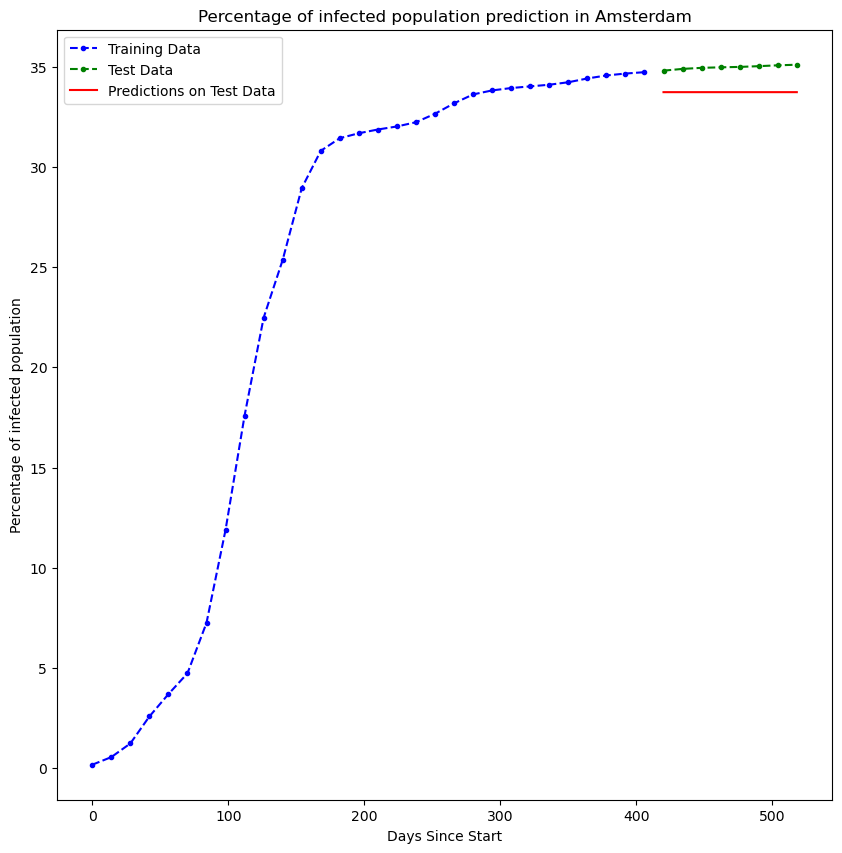

In [37]:
SELECTED_CITY = "Amsterdam"
df = pd.DataFrame(convid19_modeling_data)


# Filter by city
def filter_country(df: pd.DataFrame, cityName): 
    df = df.copy(deep=True)
    df_filtered = df[df["cityName"] == cityName]
    return df_filtered

city_1 = filter_country(df, SELECTED_CITY) # input desired city available in city_list 

X = pd.to_datetime(city_1["measurementDate"])  
X = (X - X.min()).dt.days.values.astype(float)  
y = city_1['percentageOfInfectedPopulation'].values  

split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# The Richards (generalized logistic) growth function 
def RG_logistic_growth(t, F, IR, L, C): 
    """
    t -> time, day since start 
    F -> final epidemic size 
    IR -> infection rate 
    L -> lag phase 
    C -> carrying capacity
    
    """
    numerator = F
    expo = np.exp(-IR * (t - L))
    denominator = (1 + C * expo) ** (1 / C)
    return numerator / denominator

initial_guess = [max(y_train), 0.1, np.average(X_train), 1]

optp, covp = curve_fit(RG_logistic_growth, X_train, y_train, p0=initial_guess)

F_opt, IR_opt, L_opt, C_opt = optp
print(f"Optimal Parameters: F={F_opt}, IR={IR_opt}, L={L_opt}, C={C_opt}")

y_pred = RG_logistic_growth(X_test, F_opt, IR_opt, L_opt, C_opt)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on Test Data: {mae}")

plt.figure(figsize=(10, 10))
plt.plot(X_train, y_train, 'b.', label='Training Data',linestyle="--")
plt.plot(X_test, y_test, 'g.', label='Test Data',linestyle="--")
plt.plot(X_test, y_pred, 'r-', label='Predictions on Test Data')
plt.title(f"Percentage of infected population prediction in {SELECTED_CITY}")
plt.xlabel('Days Since Start')
plt.ylabel('Percentage of infected population')
plt.legend()
plt.show()